# 1: 导入库与配置

In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as mpl_cm
from sklearn.metrics import confusion_matrix, classification_report

# 设置随机种子，保证结果可复现
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 配置参数
INPUT_SIZE = (64, 64)
NUM_CLASSES = 2
BATCH_SIZE = 32 
EPOCHS = 40     
LEARNING_RATE = 1e-4

# 创建输出目录
OUT_DIR = "outputs_40"
os.makedirs(OUT_DIR, exist_ok=True)

# 开启GPU显存按需分配
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

print("环境配置完成")

环境配置完成


# 2: 数据加载与筛选 

In [4]:
print(" 加载CIFAR-10并筛选猫狗...")
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

def select_cats_dogs(x, y):
    mask = np.isin(y.flatten(), [3, 5])  # 3=cat, 5=dog
    x_sel = x[mask]
    y_sel = y[mask].flatten()
    y_sel = np.where(y_sel == 3, 0, 1)  # 0=Cat, 1=Dog
    return x_sel, y_sel

x_train, y_train = select_cats_dogs(x_train, y_train)
x_test, y_test = select_cats_dogs(x_test, y_test)

# 独热编码
y_train_oh = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_oh = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

# 划分验证集 (10%)
val_size = int(len(x_train) * 0.1)
x_val, y_val_oh = x_train[:val_size], y_train_oh[:val_size]
x_train, y_train_oh = x_train[val_size:], y_train_oh[val_size:]

print(f"训练集: {len(x_train)}, 验证集: {len(x_val)}, 测试集: {len(x_test)}")

 加载CIFAR-10并筛选猫狗...
训练集: 9000, 验证集: 1000, 测试集: 2000


# 3: 数据管道与数据增强

In [6]:
# 定义数据增强层
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"), # 随机水平翻转
    tf.keras.layers.RandomRotation(0.1),      # 随机旋转 10%
    tf.keras.layers.RandomZoom(0.1),          # 随机缩放
])

def preprocess_image(image, label):
    image = tf.image.resize(image, INPUT_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def make_dataset(x, y, shuffle=False, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    ds = ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    # 如果是训练集，应用数据增强
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
        
    if shuffle:
        ds = ds.shuffle(buffer_size=len(x), seed=SEED)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(x_train, y_train_oh, shuffle=True, augment=True) # 开启增强
val_ds = make_dataset(x_val, y_val_oh)
test_ds = make_dataset(x_test, y_test_oh)

print("数据管道构建完成 (已启用数据增强)")

数据管道构建完成 (已启用数据增强)


# 4: 搭建模型

In [8]:
def build_model(input_shape=(64, 64, 3), num_classes=2):
    inputs = tf.keras.Input(shape=input_shape)
    
    # 卷积层堆叠
    x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = tf.keras.layers.MaxPooling2D()(x)
    
    x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    
    x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    
    # 给最后一个卷积层命名，方便后面提取特征画热力图
    x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', name='last_conv')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x) 
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    return tf.keras.Model(inputs, outputs, name="CNN")

model = build_model()
model.summary()

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 765,890 (2.92 MB)

 Trainable params: 765,890 (2.92 MB)

 Non-trainable params: 0 (0.00 B)

# 5: 模型训练 

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print(f"\n 开始训练 (Epochs: {EPOCHS})...")
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, verbose=1)

# 保存模型
model_path = os.path.join(OUT_DIR, "cat_dog_model_final.h5")
model.save(model_path)
print(f" 模型已保存至: {model_path}")


 开始训练 (Epochs: 40)...
Epoch 1/40
282/282 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.5519 - loss: 0.6843 - val_accuracy: 0.5510 - val_loss: 0.6712
Epoch 2/40
282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.5921 - loss: 0.6667 - val_accuracy: 0.6140 - val_loss: 0.6391
Epoch 3/40
282/282 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.6419 - loss: 0.6354 - val_accuracy: 0.6910 - val_loss: 0.5948
Epoch 4/40
282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.6707 - loss: 0.6130 - val_accuracy: 0.6950 - val_loss: 0.5830
Epoch 5/40
282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.6787 - loss: 0.5993 - val_accuracy: 0.6890 - val_loss: 0.5859
Epoch 6/40
282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.6957 - loss: 0.5847 - val_accuracy: 0.7110 - val_loss: 0.5607
Epoch 7/40
282/282 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.7016 - loss: 0.5725 - val_accuracy: 0.7380 - val_loss: 0.5408
Epoch 8/40
282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0

 模型已保存至: outputs_40\cat_dog_model_final.h5


# 6: 基础评估与可视化

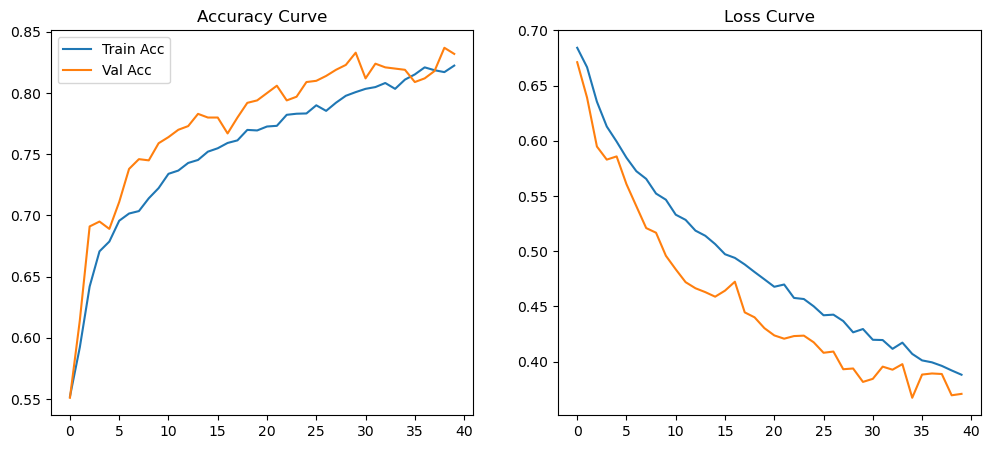

 正在评估测试集...
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step

分类报告:
               precision    recall  f1-score   support

         Cat       0.83      0.79      0.81      1000
         Dog       0.80      0.84      0.82      1000

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000



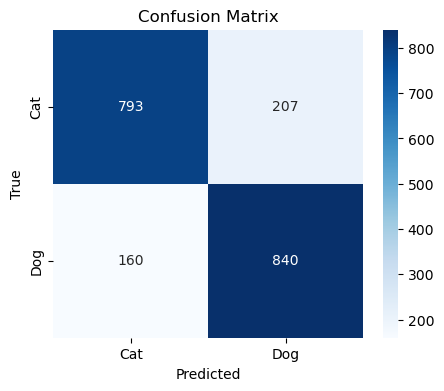

In [12]:
# 绘制训练曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.show()

# 混淆矩阵与报告
print(" 正在评估测试集...")
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_oh, axis=1)

cm = confusion_matrix(y_true, y_pred)
print("\n分类报告:\n", classification_report(y_true, y_pred, target_names=["Cat", "Dog"]))

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Cat", "Dog"], yticklabels=["Cat", "Dog"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 7: 模型可解释性 (Grad-CAM)

🔹 生成 Grad-CAM 热力图...


C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_4']]
Received: inputs=['Tensor(shape=(1, 64, 64, 3))']
  warnings.warn(msg)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_87088\113693848.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = mpl_cm.get_cmap("jet")


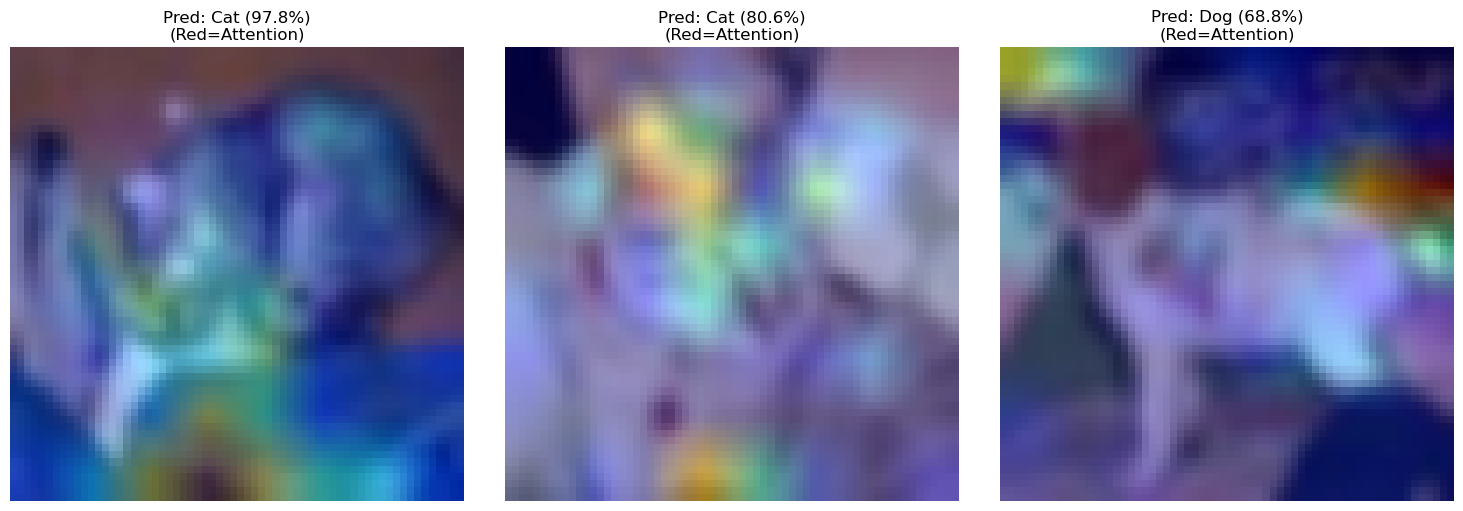

红色热力图


In [14]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img, heatmap, alpha=0.6): # 让红色更明显
    # 将热力图转换为 RGB 格式 (0-1范围)
    jet = mpl_cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3] # 取前3个通道(RGB)
    
    # 将 heatmap 映射到 0-255 用于取色
    heatmap_uint8 = np.uint8(255 * heatmap)
    jet_heatmap = jet_colors[heatmap_uint8] # 此时 jet_heatmap 是 0-1 的浮点数
    
    # 调整热力图大小以匹配原图
    jet_heatmap = tf.image.resize(jet_heatmap, (img.shape[0], img.shape[1]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
    
    # 将热力图也扩展到 0-255 范围，与原图匹配
    jet_heatmap = jet_heatmap * 255
    
    # 原图也确保是 0-255
    original_img = img * 255
    
    # 叠加 (热力图 * 强度 + 原图)
    superimposed_img = jet_heatmap * alpha + original_img
    
    # 转换回图片格式 (会自动截断超过255的值)
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img

#  随机抽取几张图进行测试 
print("🔹 生成 Grad-CAM 热力图...")
num_images = 3
plt.figure(figsize=(15, 5))

# 从测试集中取数据
for images, labels in test_ds.take(1):
    for i in range(num_images):
        img = images[i] 
        img_array = tf.expand_dims(img, axis=0)
        
        # 预测
        preds = model.predict(img_array, verbose=0)
        predicted_label = "Dog" if np.argmax(preds) == 1 else "Cat"
        confidence = np.max(preds)
        
        # 生成热力图
        heatmap = make_gradcam_heatmap(img_array, model, 'last_conv')
        result_img = display_gradcam(img, heatmap)
        
        plt.subplot(1, num_images, i+1)
        plt.imshow(result_img)
        plt.title(f"Pred: {predicted_label} ({confidence:.1%})\n(Red=Attention)")
        plt.axis('off')

plt.tight_layout()
plt.show()
print("红色热力图")

# 8: 对比实验 - 迁移学习 (ResNet50V2)

In [16]:
print("🔹 开始构建迁移学习模型 (ResNet50V2)...")

# 定义输入 
inputs = tf.keras.Input(shape=(64, 64, 3))

#  ResNet50V2 期望输入范围是 [-1, 1]
x = tf.keras.layers.Rescaling(scale=2.0, offset=-1.0)(inputs)

#  下载预训练模型
base_model = tf.keras.applications.ResNet50V2(
    input_shape=(64, 64, 3),
    include_top=False, 
    weights='imagenet'
)

# 微调策略：先冻结大部分，只解冻最后几层
base_model.trainable = True
# 冻结前 100 层，只训练后面的，让它适应猫狗数据
for layer in base_model.layers[:100]:
    layer.trainable = False

x = base_model(x, training=False) 
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x) 
outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

transfer_model = tf.keras.Model(inputs, outputs, name="Transfer_ResNet50V2")

# 编译与训练
transfer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(" 开始微调 ResNet50V2 (10 Epochs)...")
history_tl = transfer_model.fit(train_ds, validation_data=val_ds, epochs=10, verbose=1)

# 评估
tl_loss, tl_acc = transfer_model.evaluate(test_ds)
print(f"\n ResNet50V2 迁移学习测试集准确率: {tl_acc:.2%}")

🔹 开始构建迁移学习模型 (ResNet50V2)...
 开始微调 ResNet50V2 (10 Epochs)...
Epoch 1/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 168s 508ms/step - accuracy: 0.5623 - loss: 0.8915 - val_accuracy: 0.6400 - val_loss: 0.7827
Epoch 2/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 202s 507ms/step - accuracy: 0.6171 - loss: 0.7625 - val_accuracy: 0.6610 - val_loss: 0.6973
Epoch 3/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 195s 482ms/step - accuracy: 0.6538 - loss: 0.6821 - val_accuracy: 0.6930 - val_loss: 0.6263
Epoch 4/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 137s 484ms/step - accuracy: 0.6832 - loss: 0.6304 - val_accuracy: 0.7140 - val_loss: 0.5800
Epoch 5/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 133s 470ms/step - accuracy: 0.6997 - loss: 0.5919 - val_accuracy: 0.7400 - val_loss: 0.5346
Epoch 6/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 133s 472ms/step - accuracy: 0.7164 - loss: 0.5594 - val_accuracy: 0.7620 - val_loss: 0.5034
Epoch 7/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 136s 481ms/step - accuracy: 0.7281 - loss: 0.5352 - val_accuracy: 0.7760 - val_loss: 0.4777
Epoch 8/10
282/

# 9: 对比图表 (Baseline vs Transfer Learning) 

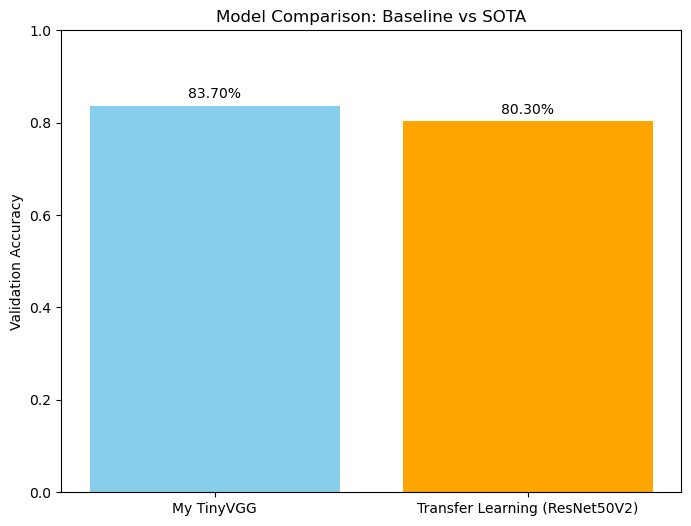

 对比完成！


In [18]:
plt.figure(figsize=(8, 6))
# 取出之前TinyVGG的最高准确率
vgg_acc = max(history.history['val_accuracy'])
# 取出MobileNet的最高准确率
mobilenet_acc = max(history_tl.history['val_accuracy'])

models = ['My TinyVGG', 'Transfer Learning (ResNet50V2)']
accs = [vgg_acc, mobilenet_acc]

bars = plt.bar(models, accs, color=['skyblue', 'orange'])
plt.ylabel('Validation Accuracy')
plt.title('Model Comparison: Baseline vs SOTA')
plt.ylim(0, 1.0)

# 在柱子上标数字
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2%}", ha='center', va='bottom')

plt.show()
print(" 对比完成！")